In [1]:
import math

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max
import cv2
import io
from pathlib import Path
from PIL import Image

In [2]:
some_tif = Path('../data/TaxolDataset/Control/img_000000091_Default_000.tif')
image = plt.imread(some_tif)

nimage = np.zeros_like(image)
nimage = cv2.normalize(image,  nimage, 0, 255, cv2.NORM_MINMAX)
intensity_trs = 50
fimage = nimage > intensity_trs

In [3]:
distance = ndi.distance_transform_edt(fimage)
peak_min_distance=55
local_maxi = peak_local_max(distance, min_distance=peak_min_distance, indices=False)

markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=image)

In [4]:
def get_img_from_fig(fig):
    buf = io.BytesIO()
    fig.savefig(buf, bbox_inches='tight', pad_inches = 0)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return img

def labels2np(labels):
    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(labels, cmap=plt.cm.nipy_spectral, aspect=1)

    return get_img_from_fig(fig)

def img2np(img):
    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(img, cmap=plt.cm.gray, aspect=1)

    return get_img_from_fig(fig)

def blend_image_and_mask(image, mask, alpha=.8, gamma=.5):
    min_h = min(image.shape[0], mask.shape[0])
    min_w = min(image.shape[1], mask.shape[1])
    image = image[:min_h, :min_w]
    mask = mask[:min_h, :min_w]

    if len(mask.shape) == 2:
        mask = np.stack([np.zeros_like(mask), mask, np.zeros_like(mask)], axis=-1)

    image = image.astype(np.uint8)
    mask = mask.astype(np.uint8)

    return cv2.addWeighted(image, alpha, mask, 1 - alpha, gamma)

In [5]:
%%capture

np_image = img2np(image);
mask_image = labels2np(labels);
blend = blend_image_and_mask(np_image, mask_image)

In [6]:
img = np.zeros_like(image)

for y, x in np.argwhere(local_maxi):
    local_maxi_vis = cv2.circle(img, (x, y), 1, (255,0,0), 10)

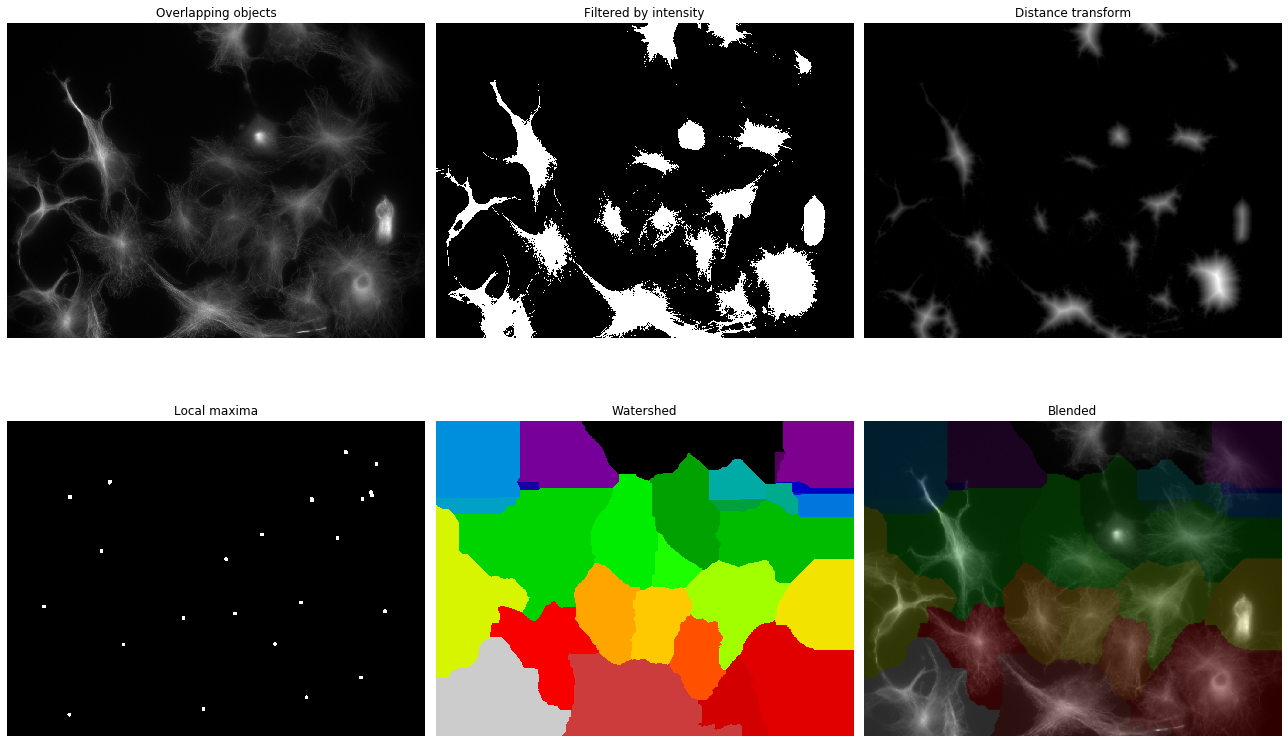

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(fimage, cmap=plt.cm.gray)
ax[1].set_title('Filtered by intensity')
ax[2].imshow(distance, cmap=plt.cm.gray)
ax[2].set_title('Distance transform')
ax[3].imshow(local_maxi_vis, cmap=plt.cm.gray)
ax[3].set_title('Local maxima')
ax[4].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[4].set_title('Watershed')
ax[5].imshow(cv2.resize(blend, (image.shape[1], image.shape[0])), cmap=plt.cm.nipy_spectral)
ax[5].set_title('Blended')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

In [8]:
def bbox(img):
    a = np.where(img != 0)
    bbox = np.min(a[0]), np.max(a[0]), np.min(a[1]), np.max(a[1])
    return bbox

In [9]:
n_labels = len(np.unique(labels))
print('Number of sells:', n_labels)

Number of sells: 29


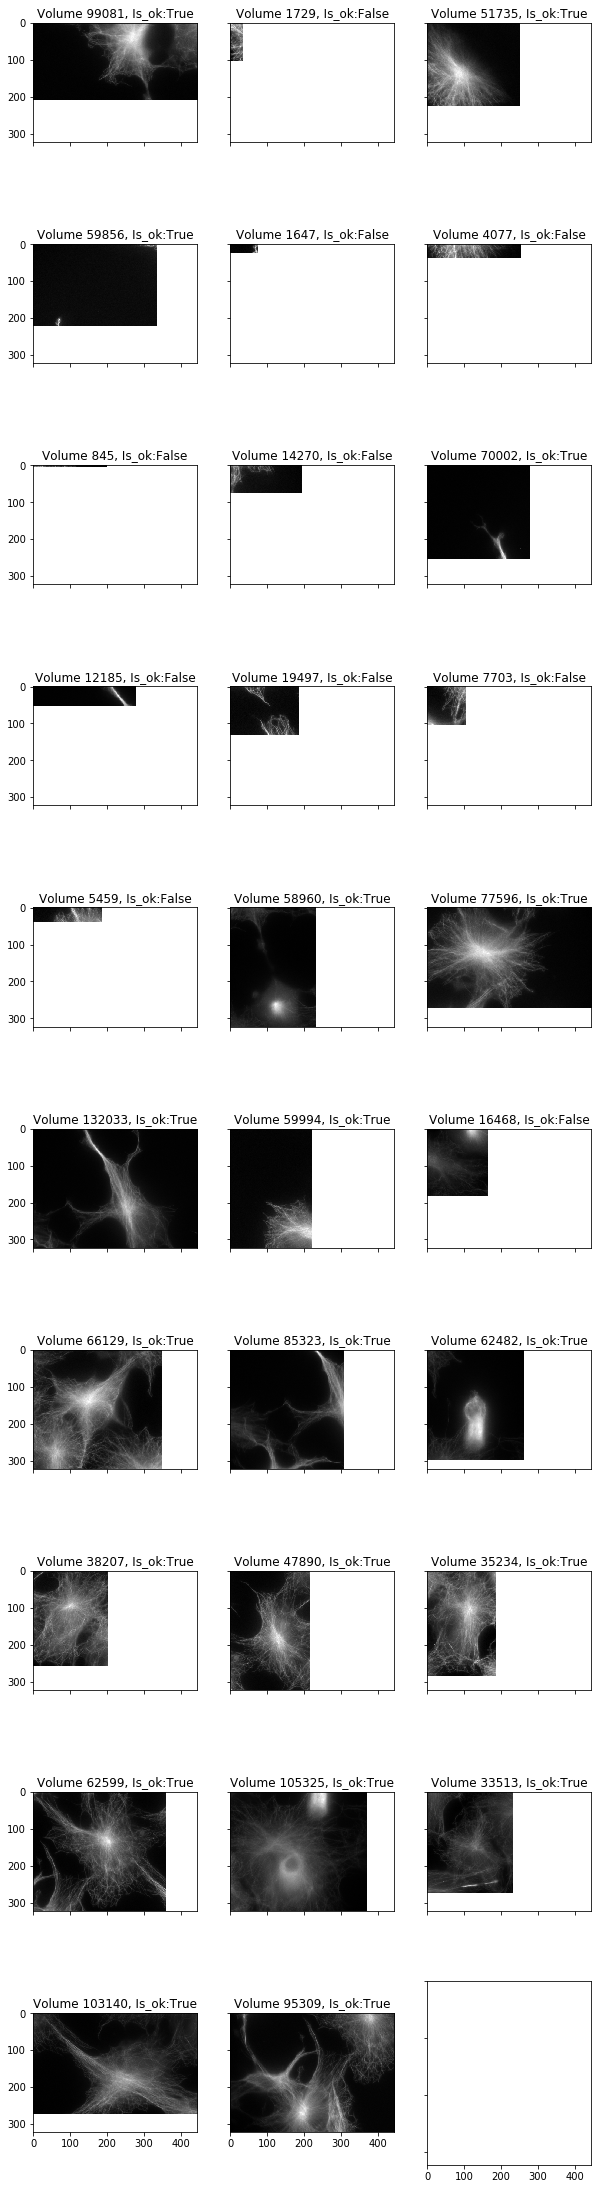

In [10]:
fig, axes = plt.subplots(nrows=math.ceil(n_labels / 3), ncols=3, figsize=(10, 40), sharex=True, sharey=True)
ax = axes.ravel()

volume_trs = 30000
for label in np.unique(labels):
    x0, x1, y0, y1 = bbox(labels == label)
    crop = image[x0:x1, y0:y1]
    ax[label - 1].imshow(crop, cmap=plt.cm.gray);
    volume = (labels == label).sum()
    ax[label - 1].set_title(f'Volume {volume}, Is_ok:{volume > volume_trs}')